# CNN from Scratch: Keras

In [24]:
import os, cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

from keras import backend as K
K.set_image_dim_ordering('th')

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam

## Load Data

In [25]:
PATH = os.getcwd()
data_path = PATH + '/data'
data_dir_list = os.listdir(data_path)
print(data_dir_list)
del data_dir_list[0]
print(data_dir_list)


img_rows=128
img_columns=128
num_channels=1

img_data_list=[]

for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+dataset)
    #print(img_list)
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        #print(input_img.shape)
        input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img=cv2.resize(input_img,(128,128))
        img_data_list.append(input_img)
        
img_data=np.array(img_data_list)
img_data=img_data.astype('float32')
img_data/=255

print(img_data.shape)

['.DS_Store', 'cats', 'dogs', 'horses', 'Humans']
['cats', 'dogs', 'horses', 'Humans']
(808, 128, 128)


## Reshaping Image to Pass it to CNN

In [26]:
#print(K.image_dim_ordering())
if num_channels==1:
    if K.image_dim_ordering()=='th':
            img_data=np.expand_dims(img_data,axis=1)
    else:
        img_data=np.expand_dims(img_data,axis=4)

else:
    if K.image_dim_ordering()=='th':
        img_data=np.rollaxis(img_data,3,1)
        
print(img_data.shape)

(808, 1, 128, 128)


In [27]:
num_classes = 4

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:202]=0
labels[202:404]=1
labels[404:606]=2
labels[606:]=3

names = ['cats','dogs','horses','humans']


Y = np_utils.to_categorical(labels, num_classes)


x,y = shuffle(img_data,Y, random_state=2)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)


## Model

In [28]:
input_shape=img_data[0].shape


model = Sequential()

model.add(Convolution2D(32, 3,3,border_mode='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=["accuracy"])
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=["accuracy"])


/Users/vduddu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", input_shape=(1, 128, 1...)`
  """
/Users/vduddu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
  import sys
/Users/vduddu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
  if sys.path[0] == '':


## Viewing Model

In [30]:
model.summary()
model.get_config()
model.layers[0].get_config()
model.layers[0].input_shape
model.layers[0].output_shape
model.layers[0].get_weights()
np.shape(model.layers[0].get_weights()[0])
model.layers[0].trainable

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 128, 128)      320       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 128, 128)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 126, 126)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 126, 126)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 63, 63)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 63, 63)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 61, 61)        18496     
__________

True

## Run Model

In [34]:
num_epoch=1
hist = model.fit(X_train, y_train, batch_size=16, nb_epoch=num_epoch, verbose=1, validation_data=(X_test, y_test))

Train on 646 samples, validate on 162 samples
Epoch 1/1
646/646 [==============================] - 139s 215ms/step - loss: 1.3447 - acc: 0.3514 - val_loss: 1.3533 - val_acc: 0.4012


## Callback

In [ ]:
# Training with callbacks
from keras import callbacks

filename='model_train_new.csv'
csv_log=callbacks.CSVLogger(filename, separator=',', append=False)

early_stopping=callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='min')

filepath="Best-weights-my_model-{epoch:03d}-{loss:.4f}-{acc:.4f}.hdf5"

checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [csv_log,early_stopping,checkpoint]

hist = model.fit(X_train, y_train, batch_size=16, nb_epoch=num_epoch, verbose=1, validation_data=(X_test, y_test),callbacks=callbacks_list)


# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(num_epoch)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])


## Evaluate Model

In [36]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

test_image = X_test[0:1]
print (test_image.shape)

print(model.predict(test_image))
print(model.predict_classes(test_image))
print(y_test[0:1])

('Test Loss:', 1.3533037621297954)
('Test accuracy:', 0.40123456790123457)
(1, 1, 128, 128)
[[ 0.23432954  0.24000673  0.29586893  0.2297948 ]]
[2]
[[ 0.  0.  1.  0.]]


## Test Image and Feature Maps

In [38]:
test_image = cv2.imread('data/Humans/rider-8.jpg')
test_image=cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
test_image=cv2.resize(test_image,(128,128))
test_image = np.array(test_image)
test_image = test_image.astype('float32')
test_image /= 255
print (test_image.shape)
   
if num_channels==1:
    if K.image_dim_ordering()=='th':
        test_image= np.expand_dims(test_image, axis=0)
        test_image= np.expand_dims(test_image, axis=0)
        print (test_image.shape)
    else:
        test_image= np.expand_dims(test_image, axis=3) 
        test_image= np.expand_dims(test_image, axis=0)
        print (test_image.shape)

else:
    if K.image_dim_ordering()=='th':
        test_image=np.rollaxis(test_image,2,0)
        test_image= np.expand_dims(test_image, axis=0)
        print (test_image.shape)
    else:
        test_image= np.expand_dims(test_image, axis=0)
        print (test_image.shape)

# Predicting the test image
print((model.predict(test_image)))
print(model.predict_classes(test_image))



(128, 128)
(1, 1, 128, 128)
[[ 0.2575646   0.23851694  0.25174993  0.25216854]]
[0]


## Visualising

(1, 1, 32, 126, 126)
(32, 126, 126)
(126, 126, 32)


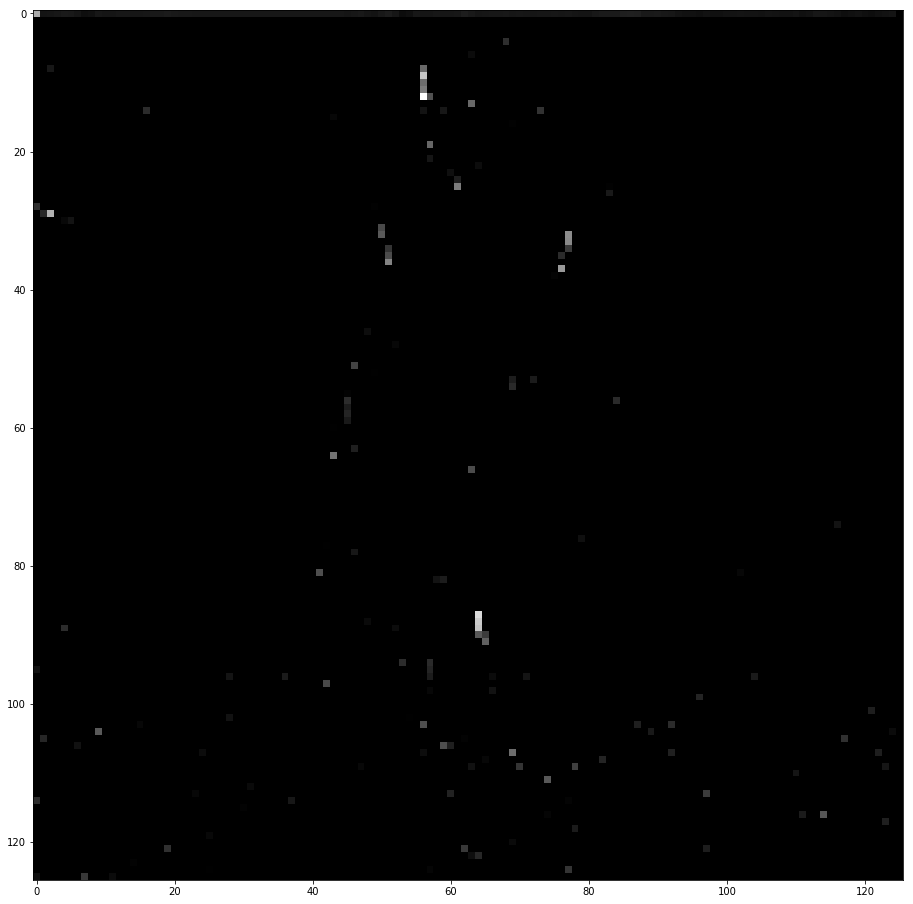

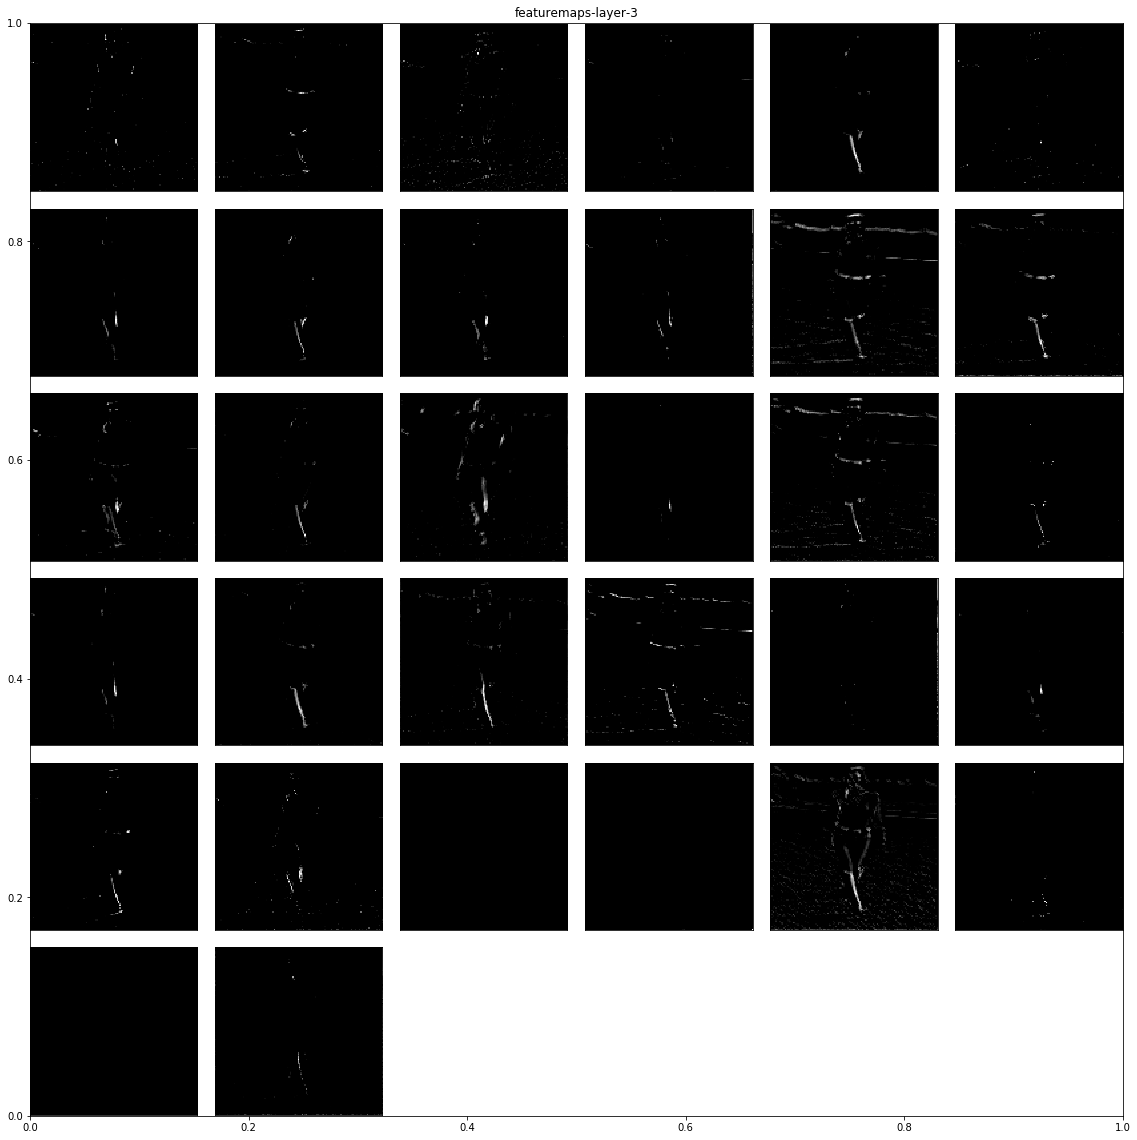

In [39]:

def get_featuremaps(model, layer_idx, X_batch):
    get_activations = K.function([model.layers[0].input, K.learning_phase()],[model.layers[layer_idx].output,])
    activations = get_activations([X_batch,0])
    return activations

layer_num=3
filter_num=0

activations = get_featuremaps(model, int(layer_num),test_image)

print (np.shape(activations))
feature_maps = activations[0][0]      
print (np.shape(feature_maps))

if K.image_dim_ordering()=='th':
    feature_maps=np.rollaxis((np.rollaxis(feature_maps,2,0)),2,0)
print (feature_maps.shape)

fig=plt.figure(figsize=(16,16))
plt.imshow(feature_maps[:,:,filter_num],cmap='gray')
plt.savefig("featuremaps-layer-{}".format(layer_num) + "-filternum-{}".format(filter_num)+'.jpg')

num_of_featuremaps=feature_maps.shape[2]
fig=plt.figure(figsize=(16,16))	
plt.title("featuremaps-layer-{}".format(layer_num))
subplot_num=int(np.ceil(np.sqrt(num_of_featuremaps)))
for i in range(int(num_of_featuremaps)):
    ax = fig.add_subplot(subplot_num, subplot_num, i+1)
    ax.imshow(feature_maps[:,:,i],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()
fig.savefig("featuremaps-layer-{}".format(layer_num) + '.jpg')

## Plot the confusion Matrix

[[ 0.23432955  0.24000673  0.29586893  0.2297948 ]
 [ 0.26546413  0.24614406  0.25186571  0.23652604]
 [ 0.26928085  0.24558246  0.25108826  0.23404844]
 [ 0.2799409   0.23725764  0.25114182  0.23165965]
 [ 0.27398366  0.2355613   0.26784119  0.22261387]
 [ 0.26246619  0.24397759  0.25200775  0.24154845]
 [ 0.26082808  0.23012432  0.25848782  0.25055972]
 [ 0.26326621  0.23071358  0.28111336  0.22490686]
 [ 0.26585552  0.24398589  0.254186    0.23597258]
 [ 0.25407264  0.23139715  0.26673508  0.24779518]
 [ 0.26583081  0.24205443  0.256073    0.23604178]
 [ 0.1860082   0.19900981  0.27740896  0.33757305]
 [ 0.26359236  0.24011819  0.24882977  0.24745965]
 [ 0.25222358  0.22639953  0.2554253   0.26595163]
 [ 0.25831991  0.2345392   0.26232588  0.24481498]
 [ 0.23132758  0.24209675  0.29715034  0.22942534]
 [ 0.26891831  0.24583539  0.24716434  0.23808195]
 [ 0.27364591  0.23079401  0.26534984  0.23021029]
 [ 0.13735223  0.16407666  0.26474276  0.43382832]
 [ 0.26502788  0.24556994  0.24

/Users/vduddu/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix, without normalization
[[38  0  1  2]
 [31  0  6  3]
 [21  0 12  0]
 [18  0 15 15]]


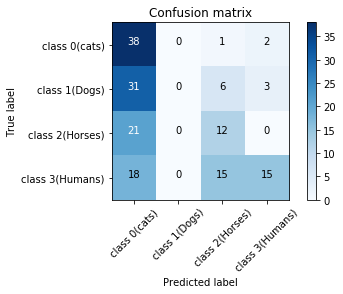

In [40]:
from sklearn.metrics import classification_report,confusion_matrix
import itertools

Y_pred = model.predict(X_test)
print(Y_pred)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)

target_names = ['class 0(cats)', 'class 1(Dogs)', 'class 2(Horses)','class 3(Humans)']

print(classification_report(np.argmax(y_test,axis=1), y_pred,target_names=target_names))

print(confusion_matrix(np.argmax(y_test,axis=1), y_pred))


# Plotting the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cnf_matrix = (confusion_matrix(np.argmax(y_test,axis=1), y_pred))

np.set_printoptions(precision=2)

plt.figure()


plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix')

plt.show()

## Save and Load Model

In [ ]:
from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

model.save('model.hdf5')
loaded_model=load_model('model.hdf5')
